In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


In [ ]:
print(torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())

Using device: cuda
Model load time: 1.60s
Loaded 998 articles in 0.03s
Sentiment analysis time: 38.60s
Price fetch time: 0.23s


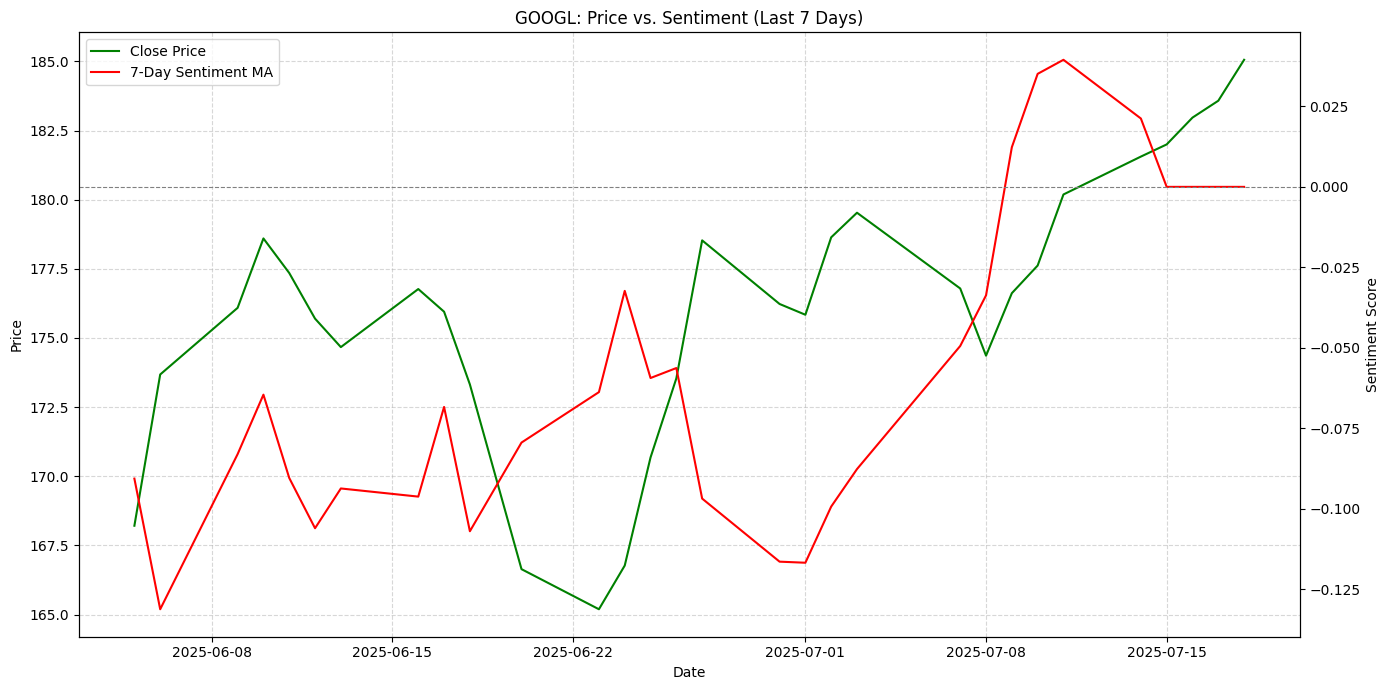

In [8]:
# visualize_sentiment.py

import os
import sys
import time
from pathlib import Path

import pandas as pd
import torch
import requests
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ─── resolve script_dir ───────────────────────────────────────────────────────
try:
    script_dir = Path(__file__).parent
except NameError:
    script_dir = Path.cwd()

proj_root = script_dir.parent
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

# ─── CONFIG ───────────────────────────────────────────────────────────────────
API_KEY    = os.getenv("FMP_API_KEY")  # your FMP key
MODEL_PATH = script_dir / "finbert-finetuned-final"
ART_DIR    = script_dir / "articles"
CHUNK_SIZE = 32     # adjust down (e.g. 16 or 8) if you still get OOM

# ─── HELPERS ──────────────────────────────────────────────────────────────────

def load_articles(ticker: str) -> pd.DataFrame:
    path = ART_DIR / f"{ticker}.csv"
    df = pd.read_csv(path, parse_dates=["publishedDate"])
    df["date"] = df["publishedDate"].dt.date
    return df

def analyze_sentiment_chunked(
    df: pd.DataFrame,
    tokenizer,
    model,
    device: torch.device,
    chunk_size: int
) -> pd.DataFrame:
    """
    Tokenize texts in chunks and run each chunk through the model on `device`.
    Sentiment score = positive_prob − negative_prob.
    """
    texts = (df["content"].fillna("") + " " + df["title"].fillna("")).tolist()
    dates = pd.to_datetime(df["date"]).tolist()
    records = []

    for i in range(0, len(texts), chunk_size):
        batch_texts = texts[i : i + chunk_size]
        batch_dates = dates[i : i + chunk_size]

        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            logits = model(**inputs).logits

        probs = torch.softmax(logits, dim=1).cpu().numpy()
        scores = probs[:, 0] - probs[:, 2]

        for d, s in zip(batch_dates, scores):
            records.append({"date": d, "sentiment": float(s)})

        # free GPU memory between chunks
        del inputs, logits, probs
        if device.type == "cuda":
            torch.cuda.empty_cache()

    return pd.DataFrame(records)

def fetch_last_7_days(ticker: str) -> pd.DataFrame:
    url = (
        f"https://financialmodelingprep.com/api/v3/"
        f"historical-price-full/{ticker}"
        f"?timeseries=30&apikey={API_KEY}"
    )
    resp = requests.get(url)
    resp.raise_for_status()
    json_resp = resp.json()
    recs = json_resp.get("historical", []) if isinstance(json_resp, dict) else []
    df = pd.DataFrame(recs)
    df["date"] = pd.to_datetime(df["date"])
    return df[["date", "close"]]

# ─── MAIN ─────────────────────────────────────────────────────────────────────

def main(ticker: str):
    # choose device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # load model & tokenizer
    t0 = time.perf_counter()
    tokenizer = AutoTokenizer.from_pretrained(str(MODEL_PATH))
    model = AutoModelForSequenceClassification.from_pretrained(
        str(MODEL_PATH),
        torch_dtype=(torch.float16 if device.type == "cuda" else torch.float32)
    )
    model.to(device).eval()
    print(f"Model load time: {time.perf_counter() - t0:.2f}s")

    # load articles
    t1 = time.perf_counter()
    art_df = load_articles(ticker)
    print(f"Loaded {len(art_df)} articles in {time.perf_counter() - t1:.2f}s")
    if art_df.empty:
        print(f"No articles found for {ticker}.")
        return

    # sentiment analysis in chunks
    t2 = time.perf_counter()
    sent_df = analyze_sentiment_chunked(art_df, tokenizer, model, device, CHUNK_SIZE)
    print(f"Sentiment analysis time: {time.perf_counter() - t2:.2f}s")

    # daily aggregation
    daily = sent_df.groupby("date", as_index=False)["sentiment"].mean()
    daily["date"] = pd.to_datetime(daily["date"])

    # fetch last 7 days of prices
    t3 = time.perf_counter()
    price_df = fetch_last_7_days(ticker)
    print(f"Price fetch time: {time.perf_counter() - t3:.2f}s")

    # merge & fill
    merged = price_df.merge(daily, on="date", how="left")
    merged["sentiment"] = merged["sentiment"].fillna(0.0)
    merged["sentiment_ma"] = merged["sentiment"].rolling(7, min_periods=1).mean()

    # plot with green price / red sentiment
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax1.plot(merged["date"], merged["close"], label="Close Price", color="green")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax2 = ax1.twinx()
    ax2.plot(
        merged["date"],
        merged["sentiment_ma"],
        label="7-Day Sentiment MA",
        color="red"
    )
    ax2.set_ylabel("Sentiment Score")
    ax2.axhline(0, linestyle="--", linewidth=0.8, color="gray")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    plt.title(f"{ticker}: Price vs. Sentiment (Last 7 Days)")
    plt.tight_layout()
    plt.show()

# ─── ENTRY POINT ──────────────────────────────────────────────────────────────

if __name__ == "__main__":
    ticker = input("Enter ticker (e.g. AAPL): ").strip().upper()
    main(ticker)


In [ ]:
# visualize_sentiment.py

import os
import sys
import time
from pathlib import Path

import pandas as pd
import torch
import requests
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ─── resolve script_dir ───────────────────────────────────────────────────────
try:
    script_dir = Path(__file__).parent
except NameError:
    script_dir = Path.cwd()

proj_root = script_dir.parent
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

# ─── CONFIG ───────────────────────────────────────────────────────────────────
API_KEY    = os.getenv("FMP_API_KEY")  # your FMP key
MODEL_PATH = script_dir / "finbert-finetuned-final"
ART_DIR    = script_dir / "articles"

# ─── HELPERS ──────────────────────────────────────────────────────────────────

def load_articles(ticker: str) -> pd.DataFrame:
    path = ART_DIR / f"{ticker}.csv"
    df = pd.read_csv(path, parse_dates=["publishedDate"])
    df["date"] = df["publishedDate"].dt.date
    return df

def analyze_sentiment_batched(df: pd.DataFrame, tokenizer, model, device) -> pd.DataFrame:
    """
    Tokenize all texts in one batch and do a single forward pass on the given device.
    Sentiment = positive_prob − negative_prob.
    """
    texts = (df["content"].fillna("") + " " + df["title"].fillna("")).tolist()
    dates = pd.to_datetime(df["date"]).tolist()

    # batch-tokenize
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )

    # move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    probs = torch.softmax(logits, dim=1).cpu().numpy()
    scores = probs[:, 0] - probs[:, 2]

    return pd.DataFrame({ "date": dates, "sentiment": scores })

def fetch_last_7_days(ticker: str) -> pd.DataFrame:
    url = (
        f"https://financialmodelingprep.com/api/v3/"
        f"historical-price-full/{ticker}"
        f"?timeseries=7&apikey={API_KEY}"
    )
    resp = requests.get(url)
    resp.raise_for_status()
    json_resp = resp.json()
    records = json_resp.get("historical", []) if isinstance(json_resp, dict) else []
    prices = pd.DataFrame(records)
    prices["date"] = pd.to_datetime(prices["date"])
    return prices[["date", "close"]]

# ─── MAIN ─────────────────────────────────────────────────────────────────────

def main(ticker: str):
    # pick GPU if you have one
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Load model & tokenizer
    t0 = time.perf_counter()
    tokenizer = AutoTokenizer.from_pretrained(str(MODEL_PATH))
    model     = AutoModelForSequenceClassification.from_pretrained(str(MODEL_PATH))
    model.to(device)
    model.eval()
    print(f"Model load time: {time.perf_counter() - t0:.2f}s")

    # 2. Load articles
    t1 = time.perf_counter()
    art_df = load_articles(ticker)
    print(f"Loaded {len(art_df)} articles in {time.perf_counter() - t1:.2f}s")

    if art_df.empty:
        print(f"No articles found for {ticker}.")
        return

    # 3. Analyze sentiment (batched on GPU)
    t2 = time.perf_counter()
    sent_df = analyze_sentiment_batched(art_df, tokenizer, model, device)
    print(f"Sentiment analysis time: {time.perf_counter() - t2:.2f}s")

    # 4. Aggregate daily
    daily = sent_df.groupby("date", as_index=False)["sentiment"].mean()
    daily["date"] = pd.to_datetime(daily["date"])

    # 5. Fetch last 7 days of prices
    t3 = time.perf_counter()
    price_df = fetch_last_7_days(ticker)
    print(f"Price fetch time: {time.perf_counter() - t3:.2f}s")

    # 6. Merge and fill missing sentiment (no chained assignment)
    merged = price_df.merge(daily, on="date", how="left")
    merged["sentiment"] = merged["sentiment"].fillna(0)
    merged["sentiment_ma"] = merged["sentiment"].rolling(7, min_periods=1).mean()

    # 7. Plot with green price / red sentiment
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax1.plot(merged["date"], merged["close"], label="Close Price", color="green")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax2 = ax1.twinx()
    ax2.plot(
        merged["date"],
        merged["sentiment_ma"],
        label="7-Day Sentiment MA",
        color="red"
    )
    ax2.set_ylabel("Sentiment Score")
    ax2.axhline(0, linestyle="--", linewidth=0.8, color="gray")

    # combine legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    plt.title(f"{ticker}: Price vs. Sentiment (Last 7 Days)")
    plt.tight_layout()
    plt.show()

# ─── ENTRY POINT ──────────────────────────────────────────────────────────────

if __name__ == "__main__":
    ticker = input("Enter ticker (e.g. AAPL): ").strip().upper()
    main(ticker)
